# Research Articles Identification

Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Given the abstract and title for a set of research articles, predict if the topic of article is related to computer science or not.

# Train Data Details -

ID - Unique ID for each article

TITLE - Title of the research article

ABSTRACT - Abstract of the research article

Computer Science - Whether article belongs to topic computer science (1/0)

In [56]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")

#import the necessary modelling algos.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from scipy.sparse import hstack

#model selection
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from nltk.stem import WordNetLemmatizer 
#import nltk
#nltk.download('wordnet')

In [2]:
# Import dataset

df = pd.read_csv("Articles.csv")
df.shape

(20972, 4)

In [3]:
df.head()

,ID,TITLE,ABSTRACT,Computer Science
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1


In [4]:
# Drop - Ignore variable, if it is not significant.

df = df.drop('ID',axis=1)

In [5]:
df.columns = ['title','abstract','ComputerScience']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            20972 non-null  object
 1   abstract         20972 non-null  object
 2   ComputerScience  20972 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 491.7+ KB


In [7]:
df.isnull().sum()

title              0
abstract           0
ComputerScience    0
dtype: int64

In [8]:
df.duplicated().sum()

0

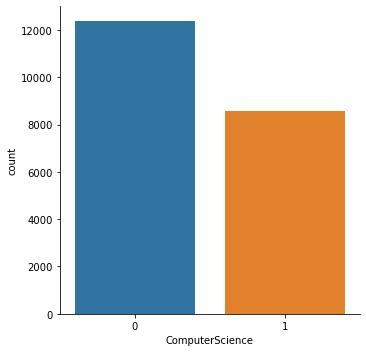

In [9]:
sns.factorplot(data=df,kind='count',size=5,aspect=1,x='ComputerScience')

In [10]:
# Converting to lower case

df['title'] = df['title'].str.lower()
df['abstract'] = df['abstract'].str.lower()
df.head()

,title,abstract,ComputerScience
0,reconstructing subject-specific effect maps,predictive models allow subject-specific inf...,1
1,rotation invariance neural network,rotation invariance and translation invarian...,1
2,spherical polyharmonics and poisson kernels fo...,we introduce and develop the notion of spher...,0
3,a finite element approximation for the stochas...,the stochastic landau--lifshitz--gilbert (ll...,0
4,comparative study of discrete wavelet transfor...,fourier-transform infra-red (ftir) spectra o...,1


In [11]:
# Removing Punctuations, Numbers, and Special Characters

df['title'] = df['title'].str.replace("[^a-zA-z]", " ") 
df['abstract'] = df['abstract'].str.replace("[^a-zA-z]", " ") 
df.head()

,title,abstract,ComputerScience
0,reconstructing subject specific effect maps,predictive models allow subject specific inf...,1
1,rotation invariance neural network,rotation invariance and translation invarian...,1
2,spherical polyharmonics and poisson kernels fo...,we introduce and develop the notion of spher...,0
3,a finite element approximation for the stochas...,the stochastic landau lifshitz gilbert ll...,0
4,comparative study of discrete wavelet transfor...,fourier transform infra red ftir spectra o...,1


In [12]:
#Removing Short Words

df['title'] = df['title'].apply(lambda old_string: ' '.join([w for w in old_string.split() if len(w)>3]))
df['abstract'] = df['abstract'].apply(lambda old_string: ' '.join([w for w in old_string.split() if len(w)>3]))
df.head()

,title,abstract,ComputerScience
0,reconstructing subject specific effect maps,predictive models allow subject specific infer...,1
1,rotation invariance neural network,rotation invariance translation invariance hav...,1
2,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,0
3,finite element approximation stochastic maxwel...,stochastic landau lifshitz gilbert equation co...,0
4,comparative study discrete wavelet transforms ...,fourier transform infra ftir spectra samples f...,1


In [13]:
# lemmatization words using NLTK

wnlemma = WordNetLemmatizer()

df['title'] = df['title'].apply(lambda text: ' '.join([wnlemma.lemmatize(word) for word in text.split()]))
df['abstract'] = df['abstract'].apply(lambda text: ' '.join([wnlemma.lemmatize(word) for word in text.split()]))
df.head()

,title,abstract,ComputerScience
0,reconstructing subject specific effect map,predictive model allow subject specific infere...,1
1,rotation invariance neural network,rotation invariance translation invariance hav...,1
2,spherical polyharmonics poisson kernel polyhar...,introduce develop notion spherical polyharmoni...,0
3,finite element approximation stochastic maxwel...,stochastic landau lifshitz gilbert equation co...,0
4,comparative study discrete wavelet transforms ...,fourier transform infra ftir spectrum sample f...,1


In [14]:
df_Y = df['ComputerScience'].values
df_X = df.drop(['ComputerScience'], axis=1)

print(df_X.shape)
print(df_Y.shape)

(20972, 2)
(20972,)


In [15]:
#---1.2 Splitting data into Train and cross validation(or test): Stratified Sampling

X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, stratify=df_Y,random_state=42)


# SET 1 - Encoding text features using BOW

In [16]:
cv = CountVectorizer(min_df=10, max_features=2000)
cv.fit(X_train['title'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = cv.transform(X_train['title'].values)
X_test_title_bow = cv.transform(X_test['title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, Y_train.shape)
print(X_test_title_bow.shape, Y_test.shape)


After vectorizations
(16777, 2000) (16777,)
(4195, 2000) (4195,)


In [17]:
cv = CountVectorizer(min_df=10, max_features=7000,stop_words = 'english')
cv.fit(X_train['abstract'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_abstract_bow = cv.transform(X_train['abstract'].values)
X_test_abstract_bow = cv.transform(X_test['abstract'].values)

print("After vectorizations")
print(X_train_abstract_bow.shape, Y_train.shape)
print(X_test_abstract_bow.shape, Y_test.shape)


After vectorizations
(16777, 7000) (16777,)
(4195, 7000) (4195,)


In [18]:
# --- Concatinating all the features

X_tr1 = hstack((X_train_title_bow, X_train_abstract_bow)).tocsr()
X_te1 = hstack((X_test_title_bow, X_test_abstract_bow)).tocsr()

print("Final Data matrix 1")
print(X_tr1.shape, Y_train.shape)
print(X_te1.shape, Y_test.shape)

Final Data matrix 1
(16777, 9000) (16777,)
(4195, 9000) (4195,)


# Modelling BOW Features

# 1.1 KNN

In [26]:
knn1 = KNeighborsClassifier()

#Hyper Parameters Set
params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}

#Making models with hyper parameters sets
model11 = RandomizedSearchCV(knn1, param_distributions = params,cv = 3, random_state = 34, n_jobs=1)

model11.fit(X_tr1,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model11.best_params_)


Best Hyper Parameters:
 {'weights': 'distance', 'n_neighbors': 6, 'n_jobs': -1, 'leaf_size': 3, 'algorithm': 'ball_tree'}


In [19]:
knn1 = KNeighborsClassifier(weights = 'distance', n_neighbors =6, n_jobs= -1, leaf_size= 3, algorithm= 'ball_tree')

knn1.fit(X_tr1,Y_train)

knn1_pred = knn1.predict(X_te1)

print(accuracy_score(Y_test,knn1_pred))

0.6798569725864124


# 1.2 LR

In [21]:
lr1 = LogisticRegression()

#Hyper Parameters Set
params = {'penalty': ['l1', 'l2', 'elasticnet'],
          'C': [0.001,0.01,0.1,1,10,100]}

#Making models with hyper parameters sets
model12 = RandomizedSearchCV(lr1, param_distributions = params,cv = 3, random_state = 34, n_jobs=1)

model12.fit(X_tr1,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model12.best_params_)


Best Hyper Parameters:
 {'penalty': 'l2', 'C': 0.1}


In [23]:
lr1 = LogisticRegression(C = 0.1, penalty = 'l2')

lr1.fit(X_tr1, Y_train)

lr1_pred = lr1.predict(X_te1)

print(accuracy_score(Y_test,lr1_pred))


0.8481525625744935


# 1.3 SVM

In [74]:
#making the instance
svc1 = SVC()

#Hyper Parameters Set
params = {'kernel': ['linear','rbf'], 
          'C' : [1,3]}

#Making models with hyper parameters sets
model13 = RandomizedSearchCV(svc1, param_distributions = params,cv = 3, random_state = 34, n_jobs=1)

#Learning
model13.fit(X_tr1,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model13.best_params_)


Best Hyper Parameters:
 {'kernel': 'rbf', 'C': 1}


In [33]:
svc1 = SVC(kernel = 'rbf', C = 1)

#Learning
svc1.fit(X_tr1, Y_train)

#Prediction
svc1_pred = svc1.predict(X_te1)

#evaluation(Accuracy)
print(accuracy_score(Y_test,svc1_pred))

0.8638855780691299


# 1.4 NB

In [57]:
#making the instance
bnb1 = BernoulliNB()

#Hyper Parameters Set
params = {'alpha': [0.1, 0.25, 0.5,0.75, 1.0, 1.25 ]}

#Making models with hyper parameters sets
model14 = RandomizedSearchCV(bnb1, param_distributions = params,cv = 3, random_state = 34, n_jobs=1)

#Learning
model14.fit(X_tr1,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model14.best_params_)


Best Hyper Parameters:
 {'alpha': 0.1}


In [58]:
bnb1 = BernoulliNB(alpha = 0.1)

#Learning
bnb1.fit(X_tr1, Y_train)

#Prediction
bnb1_pred = bnb1.predict(X_te1)

#evaluation(Accuracy)
print(accuracy_score(Y_test,bnb1_pred))

0.8448152562574494


# 1.5 DT

In [24]:
#making the instance
dt1 = DecisionTreeClassifier()

#Hyper Parameters Set
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]}

#Making models with hyper parameters sets
model15 = RandomizedSearchCV(dt1, param_distributions = params, cv = 3, random_state = 34, n_jobs=-1)

#Learning
model15.fit(X_tr1,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model15.best_params_)


Best Hyper Parameters:
 {'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt'}


In [25]:
dt1 = DecisionTreeClassifier(min_samples_split = 6,
                             min_samples_leaf = 10,
                             max_features = 'sqrt')

#Learning
dt1.fit(X_tr1, Y_train)

#Prediction
dt1_pred = dt1.predict(X_te1)

#evaluation(Accuracy)
print(accuracy_score(Y_test,dt1_pred))

0.7389749702026222


# 1.6 RF

In [26]:
#making the instance
rf1 = RandomForestClassifier()

#hyper parameters set
params = {'criterion':['gini','entropy'],
          'n_estimators':[10,15,20,25,30],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7]}

#Making models with hyper parameters sets
model16 = RandomizedSearchCV(rf1, param_distributions = params, cv = 3, random_state = 34, n_jobs=-1)

#Learning
model16.fit(X_tr1,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model16.best_params_)

Best Hyper Parameters:
 {'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'entropy'}


In [29]:
rf1 = RandomForestClassifier(criterion='entropy',
                             n_estimators = 25,
                             min_samples_split = 5,
                             min_samples_leaf = 3)

#Learning
rf1.fit(X_tr1, Y_train)

#Prediction
rf1_pred = rf1.predict(X_te1)

#evaluation(Accuracy)
print(accuracy_score(Y_test,rf1_pred))

0.834564958283671


# 1.7 XGBoost

In [43]:
#making the instance
xgb1 = XGBClassifier()

#hyper parameters set
params = {'objective' : ['binary:logistic'],
          'learning_rate' : [0.05, 0.1, 0.5, 1],
          'max_depth' : [3,5,7],
          'n_estimators':[100,400,700,1000],
          'subsample' : [0.7, 0.8, 0.9],
          'colsample_bytree' : [0.7, 0.8, 0.9]}

#Making models with hyper parameters sets
model17 = RandomizedSearchCV(xgb1, param_distributions = params, cv = 3, random_state = 34, n_jobs=-1)

#Learning
model17.fit(X_tr1,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model17.best_params_)

Best Hyper Parameters:
 {'subsample': 0.8, 'objective': 'binary:logistic', 'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [44]:
xgb1 = XGBClassifier(learning_rate =0.1,
                     n_estimators=700,
                     max_depth=7,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     objective= 'binary:logistic')

#Learning
xgb1.fit(X_tr1, Y_train)

#Prediction
xgb1_pred = xgb1.predict(X_te1)

#evaluation(Accuracy)
print(accuracy_score(Y_test,xgb1_pred))

0.8626936829558999


# 1.8 GradientBoostingClassifier

In [34]:
#making the instance
gb1 = GradientBoostingClassifier()

#hyper parameters set
params = {'loss': ['deviance'],
          'learning_rate' : [0.05, 0.1, 0.25, 0.5, 0.75, 1],
          'n_estimators':[100, 300, 500, 1000],
          'subsample' : [0.7, 0.8, 0.9],
          'max_features': ['auto', 'sqrt', 'log2'],
          'max_depth' : [3,5,7],
          'min_samples_leaf':[5,10,20],
          'min_samples_split':[20,30]}

#Making models with hyper parameters sets
model18 = RandomizedSearchCV(gb1, param_distributions = params, cv = 3, random_state = 34, n_jobs=-1)

#Learning
model18.fit(X_tr1,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model18.best_params_)

Best Hyper Parameters:
 {'subsample': 0.7, 'n_estimators': 500, 'min_samples_split': 30, 'min_samples_leaf': 20, 'max_features': 'auto', 'max_depth': 7, 'loss': 'deviance', 'learning_rate': 0.1}


In [35]:
gb1 = GradientBoostingClassifier(loss='deviance',
                                 learning_rate = 0.1,
                                 n_estimators = 500,
                                 subsample = 0.7 ,
                                 max_features = 'auto',
                                 max_depth = 7,
                                 min_samples_split = 30,
                                 min_samples_leaf = 20)

#Learning
gb1.fit(X_tr1, Y_train)

#Prediction
gb1_pred = gb1.predict(X_te1)

#evaluation(Accuracy)
print(accuracy_score(Y_test,gb1_pred))

0.8541120381406436


# SET 2 - Encoding text features using TF-IDF

In [36]:
tfv = TfidfVectorizer(min_df=10, max_features=2000)
tfv.fit(X_train['title'].values)

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_title_tfv = tfv.transform(X_train['title'].values)
X_test_title_tfv = tfv.transform(X_test['title'].values)

print("After vectorizations")
print(X_train_title_tfv.shape, Y_train.shape)
print(X_test_title_tfv.shape, Y_test.shape)


After vectorizations
(16777, 2000) (16777,)
(4195, 2000) (4195,)


In [37]:
tfv = TfidfVectorizer(min_df=10, max_features=7000,stop_words = 'english')
tfv.fit(X_train['abstract'].values)

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_abstract_tfv = tfv.transform(X_train['abstract'].values)
X_test_abstract_tfv = tfv.transform(X_test['abstract'].values)

print("After vectorizations")
print(X_train_abstract_tfv.shape, Y_train.shape)
print(X_test_abstract_tfv.shape, Y_test.shape)


After vectorizations
(16777, 7000) (16777,)
(4195, 7000) (4195,)


In [38]:
# --- Concatinating all the features

X_tr2 = hstack((X_train_title_tfv, X_train_abstract_tfv)).tocsr()
X_te2 = hstack((X_test_title_tfv, X_test_abstract_tfv)).tocsr()

print("Final Data matrix 1")
print(X_tr2.shape, Y_train.shape)
print(X_te2.shape, Y_test.shape)

Final Data matrix 1
(16777, 9000) (16777,)
(4195, 9000) (4195,)


# Modelling on TF-IDF Features

# 2.1 KNN

In [41]:
knn2 = KNeighborsClassifier()

#Hyper Parameters Set
params = {'n_neighbors':[5,9,15,21],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}

#Making models with hyper parameters sets
model21 = RandomizedSearchCV(knn1, param_distributions = params,cv = 3, random_state = 34, n_jobs=1)

model21.fit(X_tr2,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model21.best_params_)


Best Hyper Parameters:
 {'weights': 'distance', 'n_neighbors': 9, 'leaf_size': 1, 'algorithm': 'auto'}


In [45]:
knn2 = KNeighborsClassifier(weights = 'distance', n_neighbors =9, n_jobs= -1, leaf_size= 1, algorithm= 'auto')

knn2.fit(X_tr2,Y_train)

knn2_pred = knn2.predict(X_te2)

print(accuracy_score(Y_test,knn2_pred))

0.8085816448152563


# 2.2 LR

In [69]:
lr2 = LogisticRegression()

#Hyper Parameters Set
params = {'penalty': ['l1', 'l2', 'elasticnet'],
          'C': [0.001,0.01,0.1,1,10,100]}

#Making models with hyper parameters sets
model22 = RandomizedSearchCV(lr2, param_distributions = params,cv = 3, random_state = 34, n_jobs=1)

model22.fit(X_tr2,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model22.best_params_)


Best Hyper Parameters:
 {'penalty': 'l2', 'C': 0.1}


In [70]:
lr2 = LogisticRegression(penalty = 'l2', C = 0.1)

lr2.fit(X_tr2, Y_train)

lr2_pred = lr2.predict(X_te2)

print(accuracy_score(Y_test,lr2_pred))

0.8412395709177592


# 2.3 SVC

In [72]:
#making the instance
svc2 = SVC()

#Hyper Parameters Set
params = {'kernel': ['rbf'],
         'C' : [1,3]}

#Making models with hyper parameters sets
model23 = RandomizedSearchCV(svc2, param_distributions = params,cv = 3, random_state = 34, n_jobs=1)

#Learning
model23.fit(X_tr2,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model23.best_params_)


Best Hyper Parameters:
 {'kernel': 'rbf', 'C': 1}


In [47]:
svc2 = SVC(kernel='rbf', C = 1)

#Learning
svc2.fit(X_tr2, Y_train)

#Prediction
svc2_pred = svc2.predict(X_te2)

#evaluation(Accuracy)
print(accuracy_score(Y_test,svc2_pred))

0.8619785458879619


# 2.4 NB

In [60]:
#making the instance
bnb2 = BernoulliNB()

#Hyper Parameters Set
params = {'alpha': [0.1, 0.25, 0.5,0.75, 1.0, 1.25 ]}

#Making models with hyper parameters sets
model24 = RandomizedSearchCV(bnb2, param_distributions = params,cv = 3, random_state = 34, n_jobs=1)

#Learning
model24.fit(X_tr2,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model24.best_params_)


Best Hyper Parameters:
 {'alpha': 0.1}


In [61]:
bnb2 = BernoulliNB(alpha = 0.1)

#Learning
bnb2.fit(X_tr2, Y_train)

#Prediction
bnb2_pred = bnb2.predict(X_te2)

#evaluation(Accuracy)
print(accuracy_score(Y_test,bnb2_pred))

0.8448152562574494


# 2.5 DT

In [48]:
#making the instance
dt2 = DecisionTreeClassifier()

#Hyper Parameters Set
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]}

#Making models with hyper parameters sets
model25 = RandomizedSearchCV(dt2, param_distributions = params, cv = 3, random_state = 34, n_jobs=-1)

#Learning
model25.fit(X_tr2,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model25.best_params_)


Best Hyper Parameters:
 {'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'auto'}


In [49]:
dt2 = DecisionTreeClassifier(min_samples_split = 6, 
                             min_samples_leaf = 7, 
                             max_features = 'auto')

#Learning
dt2.fit(X_tr2, Y_train)

#Prediction
dt2_pred = dt2.predict(X_te2)

#evaluation(Accuracy)
print(accuracy_score(Y_test,dt2_pred))

0.7504171632896305


# 2.6 RF

In [50]:
#making the instance
rf2 = RandomForestClassifier()

#hyper parameters set
params = {'criterion':['gini','entropy'],
          'n_estimators':[10,15,20,25,30],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7]}

#Making models with hyper parameters sets
model26 = RandomizedSearchCV(rf2, param_distributions = params, cv = 3, random_state = 34, n_jobs=-1)

#Learning
model26.fit(X_tr2,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model26.best_params_)

Best Hyper Parameters:
 {'n_estimators': 30, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'entropy'}


In [51]:
rf2 = RandomForestClassifier(n_estimators = 30, 
                             min_samples_split = 7, 
                             min_samples_leaf = 3, 
                             criterion = 'entropy')

#Learning
rf2.fit(X_tr2, Y_train)

#Prediction
rf2_pred = rf2.predict(X_te2)

#evaluation(Accuracy)
print(accuracy_score(Y_test,rf2_pred))

0.8395709177592372


# 2.7 XGBoost

In [52]:
#making the instance
xgb2 = XGBClassifier()

#hyper parameters set
params = {'objective' : ['binary:logistic'],
          'learning_rate' : [0.05, 0.1, 0.5, 1],
          'max_depth' : [3,5,7],
          'n_estimators':[100,400,700,1000],
          'subsample' : [0.7, 0.8, 0.9],
          'colsample_bytree' : [0.7, 0.8, 0.9]}

#Making models with hyper parameters sets
model27 = RandomizedSearchCV(xgb2, param_distributions = params, cv = 3, random_state = 34, n_jobs=-1)

#Learning
model27.fit(X_tr2,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model27.best_params_)

Best Hyper Parameters:
 {'subsample': 0.8, 'objective': 'binary:logistic', 'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [53]:
xgb2 = XGBClassifier(learning_rate =0.1,
                     n_estimators=700,
                     max_depth=7,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     objective= 'binary:logistic')

#Learning
xgb2.fit(X_tr2, Y_train)

#Prediction
xgb2_pred = xgb2.predict(X_te2)

#evaluation(Accuracy)
print(accuracy_score(Y_test,xgb2_pred))

0.8529201430274136


# 2.8 GradientBoostingClassifier

In [54]:
#making the instance
gb2 = GradientBoostingClassifier()

#hyper parameters set
params = {'loss': ['deviance'],
          'learning_rate' : [0.05, 0.1, 0.5, 1],
          'n_estimators':[100, 300, 500, 1000],
          'subsample' : [0.7, 0.8, 0.9],
          'max_features': ['auto', 'sqrt'],
          'max_depth' : [3,5,7],
          'min_samples_leaf':[5,10],
          'min_samples_split':[20,30]}

#Making models with hyper parameters sets
model28 = RandomizedSearchCV(gb2, param_distributions = params, cv = 3, random_state = 34, n_jobs=-1)

#Learning
model28.fit(X_tr2,Y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model28.best_params_)

Best Hyper Parameters:
 {'subsample': 0.7, 'n_estimators': 1000, 'min_samples_split': 30, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.1}


In [55]:
gb2 = GradientBoostingClassifier(loss = 'deviance',
                                 learning_rate = 0.1,
                                 n_estimators = 1000,
                                 subsample = 0.7 ,
                                 max_features = 'sqrt',
                                 max_depth = 5,
                                 min_samples_split = 30,
                                 min_samples_leaf = 5)

#Learning
gb2.fit(X_tr2, Y_train)

#Prediction
gb2_pred = gb2.predict(X_te2)

#evaluation(Accuracy)
print(accuracy_score(Y_test,gb2_pred))

0.8529201430274136
